In [1]:
!pip install transformers
!pip install pytorch_lightning

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import math
from tqdm import tqdm
from PIL import Image
from transformers import CLIPTokenizer
import numpy as np

## This notebook will show the architecture of a Stable Diffusion Model

#### This is just the backbone of SD and there will be no training function here. 

#### The model will match will the pre-trained SD-1.5 from runwayml

In [3]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="runwayml/stable-diffusion-v1-5",local_dir="content/data",  filename="v1-5-pruned-emaonly.ckpt")
hf_hub_download(repo_id="runwayml/stable-diffusion-v1-5",local_dir="content/data", filename="tokenizer/merges.txt")
hf_hub_download(repo_id="runwayml/stable-diffusion-v1-5",local_dir="content/data", filename="tokenizer/vocab.json")

In [4]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


device(type='cuda')

### The architecture

This is the architecture of Latent Diffusion Model (LDM), a fundemental structure of Stable Diffusion

![](https://media.licdn.com/dms/image/D4E12AQFhF-w_XvPfrg/article-cover_image-shrink_720_1280/0/1684910043583?e=2147483647&v=beta&t=Oqmwz8mlHQU8u_WJTEgQmbO8xkWbTXxj8-PjHdK_BPg)

Look quite confusing, isn't it?

The pipeline is actually very easy to understand. 
* First the image $x$ will use **VAE Encoder** to put a image to **Latent Space** $z$. 
* What happen on the latent space is similar to **DDPM**. 
* Then the sample $\tau_\theta$ (usually noise + condition) will go through *sampling process*, an the **VAE Decoder** will convert that latent space to an image. 

The condition can be an encoded image from **Encoder** (Img2Img) and/or encoded text **CLIP** (Text2Img). Depend on condition, the output can be vary.

### VAE Encoder

On Stable Diffusion, VAE Encoder consists of 4 Downsampling Blocks. 

In [5]:
# @title VAE_Encoder
class VAE_Encoder(nn.Sequential):
  def __init__(self):
    super().__init__(

        nn.Conv2d(3,128,kernel_size=3,padding=1), # (bs, 3, h, w) -> (bs, 128, h, w)
        VAE_ResidualBlock(128,128), # (bs, 128, h, w) -> (bs, 128, h, w)
        VAE_ResidualBlock(128,128), # (bs, 128, h, w) -> (bs, 128, h, w)

        nn.Conv2d(128,128, kernel_size=3,stride=2,padding=0), # (bs, 128, h, w) -> # (bs, 128, h/2, w/2)
        VAE_ResidualBlock(128,256), # (bs, 128, h/2, w/2) -> (bs, 256, h/2, w/2)
        VAE_ResidualBlock(256,256), # (bs, 256, h/2, w/2) -> (bs, 256, h/2, w/2)

        nn.Conv2d(256,256, kernel_size=3,stride=2,padding=0),
        VAE_ResidualBlock(256,512),
        VAE_ResidualBlock(512,512),

        nn.Conv2d(512,512, kernel_size=3,stride=2,padding=0),
        VAE_ResidualBlock(512,512),
        VAE_ResidualBlock(512,512),
        VAE_ResidualBlock(512,512),
        VAE_AttentionBlock(512),
        VAE_ResidualBlock(512,512),

        nn.GroupNorm(32,512),
        nn.SiLU(),

        nn.Conv2d(512,8, kernel_size=3,padding=1),
        nn.Conv2d(8,8,kernel_size=1,padding=0)
    )
  def forward(self, x , noise):
    # x (bs,channel,height,width)
    #
    for module in self:
      if getattr(module, 'stride',None) == (2,2):
        x = F.pad(x,(0,1,0,1))
      x = module(x)

    mean, log_var = torch.chunk(x, 2, dim=1)

    log_var = torch.clamp(log_var , -30 , 20)
    var = log_var.exp()
    sigma = var.sqrt()

    x = mean + sigma*noise

    # magic parameter
    x*= 0.18125

    return x

### VAE Decoder

Similar to **VAE Encoder**, the Decoder have 4 downsampling blocks 

In [6]:
# @title VAE_Decoder
class VAE_Decoder(nn.Sequential):

  def __init__(self):
    super().__init__(
        nn.Conv2d(4,4, kernel_size=1, padding=0), # (bs, 4, h/8, w/8) -> (bs, 4, h/8, w/8)
        nn.Conv2d(4,512, kernel_size=3, padding=1), # (bs, 4, h/8, w/8) -> (bs, 512, h/8, w/8)
        VAE_ResidualBlock(512,512), # (bs, 512, h/8, w/8) -> (bs, 512, h/8, w/8)
        VAE_AttentionBlock(512), # (bs, 512, h/8, w/8) -> (bs, 512, h/8, w/8)

        VAE_ResidualBlock(512,512), # (bs, 512, h/8, w/8) -> (bs, 512, h/8, w/8)
        VAE_ResidualBlock(512,512), # (bs, 512, h/8, w/8) -> (bs, 512, h/8, w/8)
        VAE_ResidualBlock(512,512), # (bs, 512, h/8, w/8) -> (bs, 512, h/8, w/8)
        VAE_ResidualBlock(512,512), # (bs, 512, h/8, w/8) -> (bs, 512, h/8, w/8)

        nn.Upsample(scale_factor=2), # (bs, 512, h/8, w/8) -> (bs, 512, h/4, w/4)
        nn.Conv2d(512,512, kernel_size=3, padding=1), # (bs, 512, h/4, w/4) -> (bs, 512, h/4, w/4)

        VAE_ResidualBlock(512,512), # (bs, 512, h/4, w/4) -> (bs, 512, h/4, w/4)
        VAE_ResidualBlock(512,512), # (bs, 512, h/4, w/4) -> (bs, 512, h/4, w/4)
        VAE_ResidualBlock(512,512), # (bs, 512, h/4, w/4) -> (bs, 512, h/4, w/4)

        nn.Upsample(scale_factor=2), # (bs, 512, h/4, w/4) -> (bs, 512, h/2, w/2)
        nn.Conv2d(512,512, kernel_size=3, padding=1), # (bs, 512, h/2, w/2) -> (bs, 512, h/2, w/2)

        VAE_ResidualBlock(512,256), # (bs, 512, h/2, w/2) -> (bs, 256, h/2, w/2)
        VAE_ResidualBlock(256,256), # (bs, 256, h/2, w/2) -> (bs, 256, h/2, w/2)
        VAE_ResidualBlock(256,256), # (bs, 256, h/2, w/2) -> (bs, 256, h/2, w/2)

        nn.Upsample(scale_factor=2), # # (bs, 256, h/2, w/2) -> (bs, 256, h, w)
        nn.Conv2d(256,256, kernel_size=3, padding=1), # (bs, 256, h, w) -> (bs, 256, h, w)

        VAE_ResidualBlock(256,128), # (bs, 256, h, w) -> (bs, 128, h, w)
        VAE_ResidualBlock(128,128), # (bs, 128, h, w) -> (bs, 128, h, w)
        VAE_ResidualBlock(128,128), # (bs, 128, h, w) -> (bs, 128, h, w)

        nn.GroupNorm(32,128),

        nn.SiLU(),
        nn.Conv2d(128, 3, kernel_size=3, padding=1) # (bs, 128, h, w) -> (bs, 3, h, w)
    )
  def forward(self, x):
    #x (b/s,4,h/8,w/8) the latent space of image
    x/= 0.18215

    for module in self:
      x = module(x)

    return x

### Component in each VAE Block

In [7]:
# @title VAE_ResidualBlock
class VAE_ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.groupnorm_1 = nn.GroupNorm(32,in_channels)
    self.conv_1 = nn.Conv2d(in_channels,out_channels, kernel_size=3, padding=1)

    self.groupnorm_2 = nn.GroupNorm(32,out_channels)
    self.conv_2 = nn.Conv2d(out_channels,out_channels, kernel_size=3, padding=1)

    if in_channels == out_channels:
      self.residual_layer = nn.Identity()
    else:
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

  def forward(self, x):
  # x: (bs, in_channels, h, w)
    residue=x

    x = self.groupnorm_1(x)
    x = F.silu(x)
    x = self.conv_1(x) # (bs, in_channels, h, w) -> (bs, out_channels, h, w)

    x = self.groupnorm_2(x)
    x = F.silu(x)
    x = self.conv_2(x) # (bs, out_channels, h, w) -> (bs, out_channels, h, w)


    return x + self.residual_layer(residue)


In [8]:
# @title VAE_AttentionBlock
class VAE_AttentionBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.groupnorm = nn.GroupNorm(32, channels)
    self.attention = SelfAttention(1, channels)

  def forward(self, x):
    residue=x
    x = self.groupnorm(x)

    n, c, h, w = x.shape

    # (bs,f, h, w) -> (bs, h*w, f)
    x = x.view((n,c,h*w))

    # (bs,f, h*w) -> (bs, h*w, f)
    x = x.transpose(-1, -2)

    x = self.attention(x)
    # (bs, h*w, f) -> (bs, f, h*w)
    x = x.transpose(-1, -2)
    x = x.view((n,c,h,w))

    x += residue

    return x


In [9]:
# @title SelfAttention
class SelfAttention(nn.Module):
  def __init__(self, n_heads, d_model, in_proj_bias=True, out_proj_bias=True):
    super().__init__()

    self.in_proj = nn.Linear(d_model, 3*d_model, bias= in_proj_bias)
    self.out_proj= nn.Linear(d_model, d_model, bias = out_proj_bias)

    self.n_heads = n_heads
    self.d_k = d_model // n_heads

  def forward(self, x, causual_mask = False):
    # x: (bs, seq_len, dim)
    input_shape = x.shape
    batch_size, sequence_length, d_embed = input_shape

    intermin_shape = (batch_size, sequence_length, self.n_heads, self.d_k)

    # (bs, seq_len, dim) -> (bs, seq_len, h, dim/h) -> (bs,h,seq_len, dim/h)
    Q, K, V = self.in_proj(x).chunk(3, dim=-1) # Get Q, K, V

    Q = Q.view(intermin_shape).transpose(1,2)
    K = K.view(intermin_shape).transpose(1,2)
    V = V.view(intermin_shape).transpose(1,2)

    weight = Q @ K .transpose(-1,-2)

    if causual_mask: # Apply mask to upper triangle of the matrix

      mask = torch.ones_like(weight, dtype = torch.bool).triu(1)
      weight.masked_fill_(mask, -torch.inf)

    weight/= math.sqrt(self.d_k)
    weight = F.softmax(weight,dim=-1)

    output = weight @ V
    output = output.transpose(1,2)
    output = output.reshape(input_shape)
    output = self.out_proj(output)

    return output


### [CLIP](https://arxiv.org/abs/2103.00020) 

Contrastive Language–Image Pre-training (CLIP) is a multi-model, understanding the context of both image and text. It has both *Text Encoder* and *Image Encoder* to create an embedding matrix.

![CLIP](https://images.openai.com/blob/fbc4f633-9ad4-4dc2-bd94-0b6f1feee22f/overview-a.svg?width=10&height=10&quality=50)

The backbone for **Text Encoder** is usually a Transformer, and for **Image Encoder** is an image classification network such as **ResNet** or **ViT**

In this model, the author only use the text encoder of the clip

In [10]:
# @title CLIP
class CLIP(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = CLIPEmbedding(49408, 768, 77)

    self.layers = nn.ModuleList([
        CLIPLayer(12,768) for i in range (12)
    ])
    self.layernorm = nn.LayerNorm(768)

  def forward(self, tokens):
    tokens = tokens.type(torch.long)
    state = self.embedding(tokens)

    for layer in self.layers:
      state = layer(state)

    output = self.layernorm(state)

    return output

### Component of CLIP

In [11]:
# @title CLIPEmbedding
class CLIPEmbedding(nn.Module):
  def __init__(self, n_vocab, n_embd:int, n_tokens:int):
    super().__init__()

    self.token_embedding = nn.Embedding(n_vocab, n_embd)
    self.position_embedding = nn.Parameter(torch.zeros(n_tokens,n_embd))

  def forward(self,tokens):
    x = self.token_embedding(tokens)
    x+= self.position_embedding
    return x

In [12]:
# @title CLIPLayer
class CLIPLayer(nn.Module):
  def __init__(self,n_head,n_embd):
    super().__init__()
    self.layernorm_1 = nn.LayerNorm(n_embd)
    self.attention = SelfAttention(n_head,n_embd)
    self.layernorm_2 = nn.LayerNorm(n_embd)
    self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
    self.linear_2 = nn.Linear(4*n_embd, n_embd)
  def forward(self, x):

    residue = x

    # Self attention
    x = self.layernorm_1(x)
    x = self.attention(x, causual_mask=True)
    x +=residue

    # FF
    residue = x
    x = self.layernorm_2(x)
    x = self.linear_1(x)

    x = x * torch.sigmoid(1.702 * x) # Quick GELU
    x = self.linear_2(x)
    x += residue

    return x



In [14]:
# @title SwitchSequential
class SwitchSequential(nn.Sequential):
  def forward(self, x, context, time):
    for layer in self:
      if isinstance(layer, UNET_AttentionBlock):
        x = layer(x, context)
      elif isinstance(layer, UNET_ResidualBlock):
        x = layer(x, time)
      else:
        x = layer(x)

    return x

In [15]:
# @title UNET_ResidualBlock
class UNET_ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, n_time=1280):
    super().__init__()
    self.groupnorm_feature = nn.GroupNorm(32, in_channels)
    self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    self.linear_time = nn.Linear(n_time,out_channels)

    self.groupnorm_merged = nn.GroupNorm(32, out_channels)
    self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    if in_channels == out_channels:
      self.residual_layer = nn.Identity()
    else:
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

  def forward(self, feature, time):
    residue = feature

    feature = self.groupnorm_feature(feature)
    feature = F.silu(feature)

    feature = self.conv_feature(feature)

    time = F.silu(time)
    time = self.linear_time(time) # (1, 1280) -> (1, output)

    merged = feature + time.unsqueeze(-1).unsqueeze(-1)

    merged = self.groupnorm_merged(merged)

    merged = F.silu(merged)

    merged = self.conv_merged(merged)

    return merged + self.residual_layer(residue)

In [16]:
class UpSample(nn.Module):

  def __init__(self,channels):
    super().__init__()
    self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

  def forward(self, x):

    x = F.interpolate(x, scale_factor=2, mode = "nearest")
    return self.conv(x)

In [17]:
# @title CrossAttention
class CrossAttention(nn.Module):
  def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
    super().__init__()

    self.q_proj  = nn.Linear(d_embed, d_embed, bias = in_proj_bias)
    self.k_proj  = nn.Linear(d_cross, d_embed, bias = in_proj_bias)
    self.v_proj  = nn.Linear(d_cross, d_embed, bias = in_proj_bias)
    self.out_proj= nn.Linear(d_embed, d_embed, bias = out_proj_bias)

    self.n_heads = n_heads
    self.d_k = d_embed // n_heads

  def forward(self, x, y):
    # x: (bs, seq_len, dim)
    input_shape = x.shape
    batch_size, sequence_length, d_embed = input_shape

    intermin_shape = (batch_size, -1, self.n_heads, self.d_k)


    Q = self.q_proj(x)
    K = self.k_proj(y)
    V = self.v_proj(y)

    # (bs, seq_len, dim) -> (bs, seq_len, h, dim/h) -> (bs,h,seq_len, dim/h)
    Q = Q.view(intermin_shape).transpose(1,2)
    K = K.view(intermin_shape).transpose(1,2)
    V = V.view(intermin_shape).transpose(1,2)

    weight = Q @ K .transpose(-1,-2)


    weight/= math.sqrt(self.d_k)
    weight = F.softmax(weight,dim=-1)

    output = weight @ V
    output = output.transpose(1,2).contiguous()
    output = output.view(input_shape)
    output = self.out_proj(output)

    return output

In [18]:
# @title UNET_AttentionBlock
class UNET_AttentionBlock(nn.Module):
  def __init__(self, n_head, n_embd, d_context=768):
    super().__init__()
    channels = n_head * n_embd

    self.groupnorm  = nn.GroupNorm(32, channels, eps=1e-6)
    self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

    self.layernorm_1 = nn.LayerNorm(channels)
    self.attention_1 = SelfAttention(n_head, channels, in_proj_bias=False)
    self.layernorm_2 = nn.LayerNorm(channels)
    self.attention_2 = CrossAttention(n_head, channels, d_context, in_proj_bias=False)
    self.layernorm_3 = nn.LayerNorm(channels)
    self.linear_geglu_1 = nn.Linear(channels, 4 * channels * 2)
    self.linear_geglu_2 = nn.Linear(4 * channels, channels)

    self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)
  def forward(self, x, context):

    residue_long = x

    x = self.groupnorm(x)

    x = self.conv_input(x)

    n, c, h, w = x.shape

    x = x.view((n, c, h*w))

    x = x.transpose(-1, -2)

    residue_short = x
    x = self.layernorm_1(x)
    x = self.attention_1(x)
    x += residue_short

    residue_short = x

    x = self.layernorm_2(x)

    x = self.attention_2(x, context)

    x += residue_short

    residue_short = x

    x = self.layernorm_3(x)

    x, gate = self.linear_geglu_1(x).chunk(2,dim=-1)
    x = x * F.gelu(gate)

    x = self.linear_geglu_2(x)

    x += residue_short

    x = x.transpose(-1,-2)

    x = x.view((n,c,h,w))

    return self.conv_output(x) + residue_long

In [19]:
# @title UNET
class UNET(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoders = nn.ModuleList([
        # ->(bs, 320, height/8, width/8)
        SwitchSequential(nn.Conv2d(4,320, kernel_size=3, padding=1)),

        SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),

        SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),
        # -> (bs,640, h/16, w/16)
        SwitchSequential(nn.Conv2d(320,320, kernel_size=3,stride=2, padding=1)),

        SwitchSequential(UNET_ResidualBlock(320, 640), UNET_AttentionBlock(8, 80)),

        SwitchSequential(UNET_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)),
        # -> (bs,1280, h/32, w/32)
        SwitchSequential(nn.Conv2d(640,640, kernel_size=3,stride=2, padding=1)),

        SwitchSequential(UNET_ResidualBlock(640, 1280), UNET_AttentionBlock(8, 160)),

        SwitchSequential(UNET_ResidualBlock(1280, 1280), UNET_AttentionBlock(8, 160)),
        # -> (bs,1280, h/64, w/64)
        SwitchSequential(nn.Conv2d(1280,1280, kernel_size=3,stride=2, padding=1)),

        SwitchSequential(UNET_ResidualBlock(1280, 1280)),

        SwitchSequential(UNET_ResidualBlock(1280, 1280)),
    ])
    self.bottleneck = SwitchSequential(
        UNET_ResidualBlock(1280,1280),

        UNET_AttentionBlock(8,160),

        UNET_ResidualBlock(1280,1280),
    )
    self.decoders = nn.ModuleList([
        SwitchSequential(UNET_ResidualBlock(2560,1280)),

        SwitchSequential(UNET_ResidualBlock(2560,1280)),

        SwitchSequential(UNET_ResidualBlock(2560,1280), UpSample(1280)),

        SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),

        SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),

        SwitchSequential(UNET_ResidualBlock(1920, 1280), UNET_AttentionBlock(8, 160), UpSample(1280)),

        SwitchSequential(UNET_ResidualBlock(1920, 640), UNET_AttentionBlock(8, 80)),

        SwitchSequential(UNET_ResidualBlock(1280, 640), UNET_AttentionBlock(8, 80)),

        SwitchSequential(UNET_ResidualBlock(960, 640), UNET_AttentionBlock(8, 80),UpSample(640)),

        SwitchSequential(UNET_ResidualBlock(960, 320), UNET_AttentionBlock(8, 40)),

        SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),

        SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
    ])

  def forward(self, x, context, time):
        # x: (Batch_Size, 4, Height / 8, Width / 8)
        # context: (Batch_Size, Seq_Len, Dim)
        # time: (1, 1280)

        skip_connections = []
        for layers in self.encoders:
            x = layers(x, context, time)
            skip_connections.append(x)

        x = self.bottleneck(x, context, time)

        for layers in self.decoders:
            # Since we always concat with the skip connection of the encoder, the number of features increases before being sent to the decoder's layer
            x = torch.cat((x, skip_connections.pop()), dim=1)
            x = layers(x, context, time)

        return x

In [21]:
# @title UNET_OutputLayer
class UNET_OutputLayer(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.groupnorm = nn.GroupNorm(32, in_channels)
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

  def forward(self, x):
    x = self.groupnorm(x)
    x = F.silu(x)
    x = self.conv(x)

    return x

## Diffusion Model

### Time for sampling process

In [ ]:
# @title TimeEmbedding
class TimeEmbedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, 4 * n_embd)

    def forward(self, x):
        # x: (1, 320)

        # (1, 320) -> (1, 1280)
        x = self.linear_1(x)

        # (1, 1280) -> (1, 1280)
        x = F.silu(x)

        # (1, 1280) -> (1, 1280)
        x = self.linear_2(x)

        return x

### Diffusion process

In [22]:
# @title Diffusion
class Diffusion(nn.Module):
  def __init__(self):
    super().__init__()
    self.time_embedding = TimeEmbedding(320)
    self.unet = UNET()
    self.final = UNET_OutputLayer(320,4)

  def forward(self, latent, context, time):

    time = self.time_embedding(time)
    output = self.unet(latent, context, time)
    output = self.final(output)

    return output

### Sampling process

In [23]:
# @title DDPMSampler
class DDPMSampler:
  def __init__(self, generator, num_training_steps=1000, beta_start = 0.00085, beta_end = 0.0120):
    self.betas = torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_training_steps, dtype= torch.float32)**2
    self.alphas= 1.0 - self.betas

    self.alphas_bar = torch.cumprod(self.alphas,dim=0)
    self.one = torch.tensor(1.0)

    self.generator = generator
    self.num_training_steps = num_training_steps
    self.timesteps = torch.from_numpy(np.arange(0, num_training_steps)[::-1].copy())

  def set_inference_timesteps(self, num_inference_steps=50):
    self.num_inference_steps = num_inference_steps
    step_ratio = self.num_training_steps // self.num_inference_steps
    timesteps = (np.arange(0,num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
    self.timesteps = torch.from_numpy(timesteps)

  def add_noise(self, original_samples, timesteps):
    alphas_bar = self.alphas_bar.to(device= original_samples.device,dtype= original_samples.dtype)

    sqrt_alpha_bar = alphas_bar[timesteps]**0.5
    sqrt_alpha_bar = sqrt_alpha_bar.flatten()
    while len(sqrt_alpha_bar.shape) < len(original_samples.shape):
      sqrt_alpha_bar = sqrt_alpha_bar.unsqueeze(-1)

    eta = (1- alphas_bar[timesteps]) ** 0.5
    eta = eta.flatten()
    while len(eta.shape) < len(original_samples.shape):
      eta = eta.unsqueeze(-1)

    noise = torch.randn(original_samples.shape, generator= self.generator, device= original_samples.device, dtype= original_samples.dtype)
    noisy_sample = sqrt_alpha_bar * original_samples + eta * noise
    return noisy_sample

  def _get_previous_timestep(self, timestep):
    prev = timestep - (self.num_training_steps // self.num_inference_steps)
    return prev

  def _get_variance(self, timestep):
    prev_t = self._get_previous_timestep(timestep)

    alpha_bar_t = self.alphas_bar[timestep]
    alpha_bar_t_1 = self.alphas_bar[prev_t] if prev_t >=0 else self.one

    curr_alpha_t = alpha_bar_t/alpha_bar_t_1
    curr_beta_t  = 1 - curr_alpha_t

    var = (1 - alpha_bar_t_1)/(1 - alpha_bar_t)* curr_beta_t
    var = torch.clamp(var, min=1e-20)
    return var

  def step(self, timestep, latents, model_output):
    t = timestep
    prev_t = self._get_previous_timestep(t)

    alpha_bar_t = self.alphas_bar[timestep]
    alpha_bar_t_1 = self.alphas_bar[prev_t] if prev_t >=0 else self.one
    beta_bar_t = 1 - alpha_bar_t
    beta_bar_t_1 = 1 - alpha_bar_t_1

    curr_alpha_t = alpha_bar_t/alpha_bar_t_1
    curr_beta_t  = 1 - curr_alpha_t

    x0 = (latents - beta_bar_t**0.5 * model_output)/ alpha_bar_t ** 0.5
    pred_original_coeff = (alpha_bar_t_1 ** 0.5 * curr_beta_t)/beta_bar_t

    curr_sample_coeff = curr_alpha_t **0.5 * beta_bar_t_1 / beta_bar_t

    pred_mu = pred_original_coeff * x0 + curr_sample_coeff * latents

    var = 0
    if t>0:
      device = model_output.device
      noise = torch.randn(model_output.shape, generator=self.generator, device=device, dtype=model_output.dtype)
      var = (self._get_variance(t)**0.5)*noise

    pred_prev_sample = pred_mu + var

    return pred_prev_sample

  def set_strength(self, strength=1):
    start_step = self.num_inference_steps - int(self.num_inference_steps * strength)
    self.timesteps = self.timesteps[start_step:]
    self.start_step = start_step


## Stable Diffusion Generator

This is how Stable Diffusion generate image. It recieves prompts and/or image, encoding them and using sampler with vae decoder to generate image

Variable:
- `prompt`: Prompt that you want what the image should include.
- `negative_prompt`: Prompt that you want what the image should not include.
- `input_image`: conditional image 
- `strength`: process during sampling DDPM. Setting the timestamp for sampling process
- `do_cfg`: Allow negative prompt
- `cfg_scale`: Strength of prompt over negative prompts
- `sampler_name`: Sampler method. 
- `n_inference_step`: Using **DDIM** sampling method for DDPM
- `model`: Model
- `seed`: Seed for random
- `tokenizer`: Tokenizer for CLIP 


In [24]:
# @title Generator
WIDTH = 512
HEIGHT = 512
LATENTS_WIDTH  = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8

def generator(prompt, negative_prompt, input_image=None, strength=0.8, do_cfg=True,
              cfg_scale = 7.5, sampler_name="ddpm", n_inference_steps=50, models={},
              seed=None, device=None, idle_device=None, tokenizer=None):
  with torch.no_grad():
    if not (0 < strength <= 1):
      raise ValueError("?")

    if idle_device:
      to_idle = lambda x: x.to(idle_device)
    else:
      to_idle = lambda x:x
    generator = torch.Generator(device=device)
    if seed is None:
      generator.seed()
    else:
      generator.manual_seed(seed)

    CLIP = models["clip"]
    CLIP.to(device)

    if do_cfg:

      cond_tokens = tokenizer.batch_encode_plus([prompt], padding="max_length", max_length=77).input_ids

      cond_tokens = torch.tensor(cond_tokens, dtype=torch.long, device = device)

      cond_context = CLIP(cond_tokens)

      uncond_tokens = tokenizer.batch_encode_plus([negative_prompt], padding="max_length", max_length=77).input_ids

      uncond_tokens = torch.tensor(uncond_tokens, dtype=torch.long, device = device)

      uncond_context = CLIP(uncond_tokens)

      context = torch.cat([cond_context, uncond_context])
    else:

      tokens = tokenizer.batch_encode_plus([prompt], padding="max_length", max_length = 77).input_ids
      tokens = torch.tensor(tokens, dtype = torch.long, device=device)

      context = CLIP(tokens)

    to_idle(CLIP)

    if sampler_name == "ddpm":
      sampler = DDPMSampler(generator)
      sampler.set_inference_timesteps(n_inference_steps)
    else:
      raise ValueError("?")

    latents_shape = (1, 4, LATENTS_HEIGHT, LATENTS_WIDTH)

    if input_image:
      encoder = models["encoder"]
      encoder.to(device)

      input_image_tensor = input_image.resize((WIDTH, HEIGHT))
      input_image_tensor = np.array(input_image_tensor)
      input_image_tensor = torch.tensor(input_image_tensor, dtype=torch.float32)
      input_image_tensor = rescale(input_image_tensor, (0, 255), (-1, 1))

      input_image_tensor = input_image_tensor.unsqueeze(0)

      # (bs, h, w, c) -> (bs, c, h, w)
      input_image_tensor = input_image_tensor.permute(0, 3, 1, 2)

      encoder_noise = torch.randn(latents_shape, generator= generator, device=device)
      latents = encoder(input_image_tensor, encoder_noise)
      sampler.set_strength(strength=strength)
      latents = sampler.add_noise(latents, sampler.timesteps[0])

      to_idle(encoder)
    else:
      # Text -> Img: Random noise
      latents = torch.randn(latents_shape, generator = generator, device = device)

    diffusion = models["diffusion"]
    diffusion.to(device)

    timesteps = tqdm(sampler.timesteps)
    for i, timestep in enumerate(timesteps):
      time_embedding = get_time_embedding(timestep).to(device)

      model_input = latents

      if do_cfg:
        model_input = model_input.repeat(2,1,1,1)
      model_output = diffusion(model_input, context, time_embedding)

      if do_cfg:
        output_cond, output_uncond = model_output.chunk(2)
        model_output = cfg_scale * (output_cond - output_uncond) + output_cond

      latents = sampler.step(timestep, latents, model_output)

    to_idle(diffusion)
    decoder = models["decoder"]
    decoder.to(device)

    images = decoder(latents)
    to_idle(decoder)

    images = rescale(images, (-1, 1), (0, 255), clamp=True)
    images = images.permute(0, 2, 3, 1)
    images = images.to("cpu", torch.uint8).numpy()
    return images[0]

def rescale(x, old_range, new_range, clamp= False):
  old_min, old_max = old_range
  new_min, new_max = new_range

  x -= old_min
  x *= (new_max - new_min) / (old_max - old_min)
  x += new_min

  if clamp:
    x = x.clamp(new_min, new_max)
  return x

def get_time_embedding(timestep):

  freqs = torch.pow(10000, -torch.arange(start=0, end=160, dtype=torch.float32)/160)
  x = torch.tensor([timestep], dtype=torch.float32)[:,None] * freqs[None]

  return torch.cat([torch.cos(x),torch.sin(x)], dim = -1)

### Mapping the model to a pre-trained SD 1.5

In [25]:
# @title model_convert
def load_from_standard_weights(input_file: str, device: str) -> dict[str, torch.Tensor]:
    # Taken from: https://github.com/kjsman/stable-diffusion-pytorch/issues/7#issuecomment-1426839447
    original_model = torch.load(input_file, map_location=device, weights_only = False)["state_dict"]

    converted = {}
    converted['diffusion'] = {}
    converted['encoder'] = {}
    converted['decoder'] = {}
    converted['clip'] = {}

    converted['diffusion']['time_embedding.linear_1.weight'] = original_model['model.diffusion_model.time_embed.0.weight']
    converted['diffusion']['time_embedding.linear_1.bias'] = original_model['model.diffusion_model.time_embed.0.bias']
    converted['diffusion']['time_embedding.linear_2.weight'] = original_model['model.diffusion_model.time_embed.2.weight']
    converted['diffusion']['time_embedding.linear_2.bias'] = original_model['model.diffusion_model.time_embed.2.bias']
    converted['diffusion']['unet.encoders.0.0.weight'] = original_model['model.diffusion_model.input_blocks.0.0.weight']
    converted['diffusion']['unet.encoders.0.0.bias'] = original_model['model.diffusion_model.input_blocks.0.0.bias']
    converted['diffusion']['unet.encoders.1.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.1.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.1.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.1.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.1.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.1.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.1.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.1.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.1.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.1.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.1.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.1.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.1.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.1.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.1.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.1.1.norm.weight']
    converted['diffusion']['unet.encoders.1.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.1.1.norm.bias']
    converted['diffusion']['unet.encoders.1.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.1.1.proj_in.weight']
    converted['diffusion']['unet.encoders.1.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.1.1.proj_in.bias']
    converted['diffusion']['unet.encoders.1.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.1.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.1.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.1.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.1.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.1.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.1.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.1.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.1.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.1.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.1.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.1.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.1.1.proj_out.weight']
    converted['diffusion']['unet.encoders.1.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.1.1.proj_out.bias']
    converted['diffusion']['unet.encoders.2.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.2.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.2.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.2.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.2.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.2.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.2.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.2.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.2.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.2.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.2.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.2.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.2.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.2.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.2.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.2.1.norm.weight']
    converted['diffusion']['unet.encoders.2.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.2.1.norm.bias']
    converted['diffusion']['unet.encoders.2.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.2.1.proj_in.weight']
    converted['diffusion']['unet.encoders.2.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.2.1.proj_in.bias']
    converted['diffusion']['unet.encoders.2.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.2.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.2.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.2.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.2.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.2.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.2.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.2.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.2.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.2.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.2.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.2.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.2.1.proj_out.weight']
    converted['diffusion']['unet.encoders.2.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.2.1.proj_out.bias']
    converted['diffusion']['unet.encoders.3.0.weight'] = original_model['model.diffusion_model.input_blocks.3.0.op.weight']
    converted['diffusion']['unet.encoders.3.0.bias'] = original_model['model.diffusion_model.input_blocks.3.0.op.bias']
    converted['diffusion']['unet.encoders.4.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.4.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.4.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.4.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.4.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.4.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.4.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.4.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.4.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.4.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.4.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.4.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.4.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.4.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.4.0.residual_layer.weight'] = original_model['model.diffusion_model.input_blocks.4.0.skip_connection.weight']
    converted['diffusion']['unet.encoders.4.0.residual_layer.bias'] = original_model['model.diffusion_model.input_blocks.4.0.skip_connection.bias']
    converted['diffusion']['unet.encoders.4.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.4.1.norm.weight']
    converted['diffusion']['unet.encoders.4.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.4.1.norm.bias']
    converted['diffusion']['unet.encoders.4.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.4.1.proj_in.weight']
    converted['diffusion']['unet.encoders.4.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.4.1.proj_in.bias']
    converted['diffusion']['unet.encoders.4.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.4.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.4.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.4.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.4.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.4.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.4.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.4.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.4.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.4.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.4.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.4.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.4.1.proj_out.weight']
    converted['diffusion']['unet.encoders.4.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.4.1.proj_out.bias']
    converted['diffusion']['unet.encoders.5.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.5.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.5.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.5.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.5.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.5.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.5.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.5.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.5.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.5.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.5.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.5.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.5.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.5.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.5.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.5.1.norm.weight']
    converted['diffusion']['unet.encoders.5.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.5.1.norm.bias']
    converted['diffusion']['unet.encoders.5.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.5.1.proj_in.weight']
    converted['diffusion']['unet.encoders.5.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.5.1.proj_in.bias']
    converted['diffusion']['unet.encoders.5.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.5.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.5.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.5.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.5.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.5.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.5.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.5.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.5.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.5.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.5.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.5.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.5.1.proj_out.weight']
    converted['diffusion']['unet.encoders.5.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.5.1.proj_out.bias']
    converted['diffusion']['unet.encoders.6.0.weight'] = original_model['model.diffusion_model.input_blocks.6.0.op.weight']
    converted['diffusion']['unet.encoders.6.0.bias'] = original_model['model.diffusion_model.input_blocks.6.0.op.bias']
    converted['diffusion']['unet.encoders.7.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.7.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.7.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.7.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.7.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.7.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.7.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.7.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.7.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.7.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.7.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.7.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.7.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.7.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.7.0.residual_layer.weight'] = original_model['model.diffusion_model.input_blocks.7.0.skip_connection.weight']
    converted['diffusion']['unet.encoders.7.0.residual_layer.bias'] = original_model['model.diffusion_model.input_blocks.7.0.skip_connection.bias']
    converted['diffusion']['unet.encoders.7.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.7.1.norm.weight']
    converted['diffusion']['unet.encoders.7.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.7.1.norm.bias']
    converted['diffusion']['unet.encoders.7.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.7.1.proj_in.weight']
    converted['diffusion']['unet.encoders.7.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.7.1.proj_in.bias']
    converted['diffusion']['unet.encoders.7.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.7.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.7.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.7.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.7.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.7.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.7.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.7.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.7.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.7.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.7.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.7.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.7.1.proj_out.weight']
    converted['diffusion']['unet.encoders.7.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.7.1.proj_out.bias']
    converted['diffusion']['unet.encoders.8.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.8.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.8.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.8.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.8.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.8.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.8.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.8.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.8.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.8.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.8.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.8.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.8.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.8.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.8.1.groupnorm.weight'] = original_model['model.diffusion_model.input_blocks.8.1.norm.weight']
    converted['diffusion']['unet.encoders.8.1.groupnorm.bias'] = original_model['model.diffusion_model.input_blocks.8.1.norm.bias']
    converted['diffusion']['unet.encoders.8.1.conv_input.weight'] = original_model['model.diffusion_model.input_blocks.8.1.proj_in.weight']
    converted['diffusion']['unet.encoders.8.1.conv_input.bias'] = original_model['model.diffusion_model.input_blocks.8.1.proj_in.bias']
    converted['diffusion']['unet.encoders.8.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.encoders.8.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.encoders.8.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.encoders.8.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.encoders.8.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.encoders.8.1.layernorm_1.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.encoders.8.1.layernorm_1.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.encoders.8.1.layernorm_2.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.encoders.8.1.layernorm_2.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.encoders.8.1.layernorm_3.weight'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.encoders.8.1.layernorm_3.bias'] = original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.encoders.8.1.conv_output.weight'] = original_model['model.diffusion_model.input_blocks.8.1.proj_out.weight']
    converted['diffusion']['unet.encoders.8.1.conv_output.bias'] = original_model['model.diffusion_model.input_blocks.8.1.proj_out.bias']
    converted['diffusion']['unet.encoders.9.0.weight'] = original_model['model.diffusion_model.input_blocks.9.0.op.weight']
    converted['diffusion']['unet.encoders.9.0.bias'] = original_model['model.diffusion_model.input_blocks.9.0.op.bias']
    converted['diffusion']['unet.encoders.10.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.10.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.10.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.10.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.10.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.10.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.10.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.10.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.10.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.10.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.10.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.10.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.10.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.10.0.out_layers.3.bias']
    converted['diffusion']['unet.encoders.11.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.0.weight']
    converted['diffusion']['unet.encoders.11.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.0.bias']
    converted['diffusion']['unet.encoders.11.0.conv_feature.weight'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.2.weight']
    converted['diffusion']['unet.encoders.11.0.conv_feature.bias'] = original_model['model.diffusion_model.input_blocks.11.0.in_layers.2.bias']
    converted['diffusion']['unet.encoders.11.0.linear_time.weight'] = original_model['model.diffusion_model.input_blocks.11.0.emb_layers.1.weight']
    converted['diffusion']['unet.encoders.11.0.linear_time.bias'] = original_model['model.diffusion_model.input_blocks.11.0.emb_layers.1.bias']
    converted['diffusion']['unet.encoders.11.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.0.weight']
    converted['diffusion']['unet.encoders.11.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.0.bias']
    converted['diffusion']['unet.encoders.11.0.conv_merged.weight'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.3.weight']
    converted['diffusion']['unet.encoders.11.0.conv_merged.bias'] = original_model['model.diffusion_model.input_blocks.11.0.out_layers.3.bias']
    converted['diffusion']['unet.bottleneck.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.middle_block.0.in_layers.0.weight']
    converted['diffusion']['unet.bottleneck.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.middle_block.0.in_layers.0.bias']
    converted['diffusion']['unet.bottleneck.0.conv_feature.weight'] = original_model['model.diffusion_model.middle_block.0.in_layers.2.weight']
    converted['diffusion']['unet.bottleneck.0.conv_feature.bias'] = original_model['model.diffusion_model.middle_block.0.in_layers.2.bias']
    converted['diffusion']['unet.bottleneck.0.linear_time.weight'] = original_model['model.diffusion_model.middle_block.0.emb_layers.1.weight']
    converted['diffusion']['unet.bottleneck.0.linear_time.bias'] = original_model['model.diffusion_model.middle_block.0.emb_layers.1.bias']
    converted['diffusion']['unet.bottleneck.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.middle_block.0.out_layers.0.weight']
    converted['diffusion']['unet.bottleneck.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.middle_block.0.out_layers.0.bias']
    converted['diffusion']['unet.bottleneck.0.conv_merged.weight'] = original_model['model.diffusion_model.middle_block.0.out_layers.3.weight']
    converted['diffusion']['unet.bottleneck.0.conv_merged.bias'] = original_model['model.diffusion_model.middle_block.0.out_layers.3.bias']
    converted['diffusion']['unet.bottleneck.1.groupnorm.weight'] = original_model['model.diffusion_model.middle_block.1.norm.weight']
    converted['diffusion']['unet.bottleneck.1.groupnorm.bias'] = original_model['model.diffusion_model.middle_block.1.norm.bias']
    converted['diffusion']['unet.bottleneck.1.conv_input.weight'] = original_model['model.diffusion_model.middle_block.1.proj_in.weight']
    converted['diffusion']['unet.bottleneck.1.conv_input.bias'] = original_model['model.diffusion_model.middle_block.1.proj_in.bias']
    converted['diffusion']['unet.bottleneck.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.bottleneck.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.bottleneck.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.bottleneck.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.bottleneck.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.bottleneck.1.layernorm_1.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.bottleneck.1.layernorm_1.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.bottleneck.1.layernorm_2.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.bottleneck.1.layernorm_2.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.bottleneck.1.layernorm_3.weight'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.bottleneck.1.layernorm_3.bias'] = original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.bottleneck.1.conv_output.weight'] = original_model['model.diffusion_model.middle_block.1.proj_out.weight']
    converted['diffusion']['unet.bottleneck.1.conv_output.bias'] = original_model['model.diffusion_model.middle_block.1.proj_out.bias']
    converted['diffusion']['unet.bottleneck.2.groupnorm_feature.weight'] = original_model['model.diffusion_model.middle_block.2.in_layers.0.weight']
    converted['diffusion']['unet.bottleneck.2.groupnorm_feature.bias'] = original_model['model.diffusion_model.middle_block.2.in_layers.0.bias']
    converted['diffusion']['unet.bottleneck.2.conv_feature.weight'] = original_model['model.diffusion_model.middle_block.2.in_layers.2.weight']
    converted['diffusion']['unet.bottleneck.2.conv_feature.bias'] = original_model['model.diffusion_model.middle_block.2.in_layers.2.bias']
    converted['diffusion']['unet.bottleneck.2.linear_time.weight'] = original_model['model.diffusion_model.middle_block.2.emb_layers.1.weight']
    converted['diffusion']['unet.bottleneck.2.linear_time.bias'] = original_model['model.diffusion_model.middle_block.2.emb_layers.1.bias']
    converted['diffusion']['unet.bottleneck.2.groupnorm_merged.weight'] = original_model['model.diffusion_model.middle_block.2.out_layers.0.weight']
    converted['diffusion']['unet.bottleneck.2.groupnorm_merged.bias'] = original_model['model.diffusion_model.middle_block.2.out_layers.0.bias']
    converted['diffusion']['unet.bottleneck.2.conv_merged.weight'] = original_model['model.diffusion_model.middle_block.2.out_layers.3.weight']
    converted['diffusion']['unet.bottleneck.2.conv_merged.bias'] = original_model['model.diffusion_model.middle_block.2.out_layers.3.bias']
    converted['diffusion']['unet.decoders.0.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.0.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.0.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.0.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.0.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.0.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.0.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.0.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.0.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.0.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.0.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.0.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.0.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.0.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.0.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.0.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.0.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.0.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.1.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.1.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.1.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.1.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.1.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.1.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.1.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.1.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.1.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.1.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.1.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.1.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.1.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.1.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.1.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.1.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.1.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.1.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.2.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.2.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.2.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.2.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.2.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.2.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.2.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.2.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.2.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.2.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.2.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.2.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.2.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.2.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.2.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.2.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.2.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.2.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.2.1.conv.weight'] = original_model['model.diffusion_model.output_blocks.2.1.conv.weight']
    converted['diffusion']['unet.decoders.2.1.conv.bias'] = original_model['model.diffusion_model.output_blocks.2.1.conv.bias']
    converted['diffusion']['unet.decoders.3.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.3.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.3.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.3.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.3.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.3.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.3.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.3.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.3.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.3.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.3.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.3.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.3.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.3.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.3.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.3.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.3.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.3.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.3.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.3.1.norm.weight']
    converted['diffusion']['unet.decoders.3.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.3.1.norm.bias']
    converted['diffusion']['unet.decoders.3.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.3.1.proj_in.weight']
    converted['diffusion']['unet.decoders.3.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.3.1.proj_in.bias']
    converted['diffusion']['unet.decoders.3.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.3.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.3.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.3.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.3.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.3.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.3.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.3.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.3.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.3.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.3.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.3.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.3.1.proj_out.weight']
    converted['diffusion']['unet.decoders.3.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.3.1.proj_out.bias']
    converted['diffusion']['unet.decoders.4.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.4.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.4.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.4.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.4.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.4.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.4.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.4.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.4.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.4.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.4.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.4.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.4.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.4.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.4.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.4.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.4.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.4.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.4.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.4.1.norm.weight']
    converted['diffusion']['unet.decoders.4.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.4.1.norm.bias']
    converted['diffusion']['unet.decoders.4.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.4.1.proj_in.weight']
    converted['diffusion']['unet.decoders.4.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.4.1.proj_in.bias']
    converted['diffusion']['unet.decoders.4.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.4.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.4.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.4.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.4.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.4.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.4.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.4.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.4.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.4.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.4.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.4.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.4.1.proj_out.weight']
    converted['diffusion']['unet.decoders.4.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.4.1.proj_out.bias']
    converted['diffusion']['unet.decoders.5.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.5.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.5.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.5.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.5.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.5.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.5.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.5.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.5.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.5.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.5.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.5.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.5.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.5.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.5.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.5.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.5.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.5.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.5.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.5.1.norm.weight']
    converted['diffusion']['unet.decoders.5.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.5.1.norm.bias']
    converted['diffusion']['unet.decoders.5.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.5.1.proj_in.weight']
    converted['diffusion']['unet.decoders.5.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.5.1.proj_in.bias']
    converted['diffusion']['unet.decoders.5.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.5.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.5.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.5.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.5.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.5.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.5.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.5.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.5.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.5.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.5.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.5.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.5.1.proj_out.weight']
    converted['diffusion']['unet.decoders.5.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.5.1.proj_out.bias']
    converted['diffusion']['unet.decoders.5.2.conv.weight'] = original_model['model.diffusion_model.output_blocks.5.2.conv.weight']
    converted['diffusion']['unet.decoders.5.2.conv.bias'] = original_model['model.diffusion_model.output_blocks.5.2.conv.bias']
    converted['diffusion']['unet.decoders.6.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.6.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.6.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.6.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.6.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.6.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.6.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.6.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.6.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.6.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.6.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.6.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.6.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.6.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.6.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.6.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.6.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.6.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.6.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.6.1.norm.weight']
    converted['diffusion']['unet.decoders.6.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.6.1.norm.bias']
    converted['diffusion']['unet.decoders.6.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.6.1.proj_in.weight']
    converted['diffusion']['unet.decoders.6.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.6.1.proj_in.bias']
    converted['diffusion']['unet.decoders.6.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.6.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.6.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.6.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.6.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.6.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.6.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.6.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.6.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.6.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.6.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.6.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.6.1.proj_out.weight']
    converted['diffusion']['unet.decoders.6.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.6.1.proj_out.bias']
    converted['diffusion']['unet.decoders.7.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.7.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.7.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.7.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.7.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.7.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.7.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.7.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.7.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.7.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.7.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.7.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.7.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.7.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.7.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.7.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.7.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.7.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.7.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.7.1.norm.weight']
    converted['diffusion']['unet.decoders.7.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.7.1.norm.bias']
    converted['diffusion']['unet.decoders.7.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.7.1.proj_in.weight']
    converted['diffusion']['unet.decoders.7.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.7.1.proj_in.bias']
    converted['diffusion']['unet.decoders.7.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.7.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.7.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.7.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.7.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.7.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.7.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.7.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.7.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.7.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.7.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.7.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.7.1.proj_out.weight']
    converted['diffusion']['unet.decoders.7.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.7.1.proj_out.bias']
    converted['diffusion']['unet.decoders.8.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.8.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.8.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.8.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.8.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.8.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.8.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.8.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.8.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.8.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.8.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.8.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.8.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.8.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.8.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.8.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.8.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.8.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.8.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.8.1.norm.weight']
    converted['diffusion']['unet.decoders.8.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.8.1.norm.bias']
    converted['diffusion']['unet.decoders.8.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.8.1.proj_in.weight']
    converted['diffusion']['unet.decoders.8.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.8.1.proj_in.bias']
    converted['diffusion']['unet.decoders.8.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.8.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.8.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.8.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.8.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.8.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.8.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.8.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.8.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.8.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.8.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.8.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.8.1.proj_out.weight']
    converted['diffusion']['unet.decoders.8.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.8.1.proj_out.bias']
    converted['diffusion']['unet.decoders.8.2.conv.weight'] = original_model['model.diffusion_model.output_blocks.8.2.conv.weight']
    converted['diffusion']['unet.decoders.8.2.conv.bias'] = original_model['model.diffusion_model.output_blocks.8.2.conv.bias']
    converted['diffusion']['unet.decoders.9.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.9.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.9.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.9.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.9.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.9.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.9.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.9.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.9.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.9.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.9.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.9.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.9.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.9.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.9.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.9.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.9.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.9.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.9.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.9.1.norm.weight']
    converted['diffusion']['unet.decoders.9.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.9.1.norm.bias']
    converted['diffusion']['unet.decoders.9.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.9.1.proj_in.weight']
    converted['diffusion']['unet.decoders.9.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.9.1.proj_in.bias']
    converted['diffusion']['unet.decoders.9.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.9.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.9.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.9.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.9.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.9.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.9.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.9.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.9.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.9.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.9.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.9.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.9.1.proj_out.weight']
    converted['diffusion']['unet.decoders.9.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.9.1.proj_out.bias']
    converted['diffusion']['unet.decoders.10.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.10.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.10.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.10.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.10.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.10.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.10.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.10.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.10.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.10.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.10.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.10.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.10.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.10.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.10.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.10.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.10.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.10.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.10.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.10.1.norm.weight']
    converted['diffusion']['unet.decoders.10.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.10.1.norm.bias']
    converted['diffusion']['unet.decoders.10.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.10.1.proj_in.weight']
    converted['diffusion']['unet.decoders.10.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.10.1.proj_in.bias']
    converted['diffusion']['unet.decoders.10.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.10.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.10.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.10.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.10.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.10.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.10.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.10.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.10.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.10.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.10.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.10.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.10.1.proj_out.weight']
    converted['diffusion']['unet.decoders.10.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.10.1.proj_out.bias']
    converted['diffusion']['unet.decoders.11.0.groupnorm_feature.weight'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.0.weight']
    converted['diffusion']['unet.decoders.11.0.groupnorm_feature.bias'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.0.bias']
    converted['diffusion']['unet.decoders.11.0.conv_feature.weight'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.2.weight']
    converted['diffusion']['unet.decoders.11.0.conv_feature.bias'] = original_model['model.diffusion_model.output_blocks.11.0.in_layers.2.bias']
    converted['diffusion']['unet.decoders.11.0.linear_time.weight'] = original_model['model.diffusion_model.output_blocks.11.0.emb_layers.1.weight']
    converted['diffusion']['unet.decoders.11.0.linear_time.bias'] = original_model['model.diffusion_model.output_blocks.11.0.emb_layers.1.bias']
    converted['diffusion']['unet.decoders.11.0.groupnorm_merged.weight'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.0.weight']
    converted['diffusion']['unet.decoders.11.0.groupnorm_merged.bias'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.0.bias']
    converted['diffusion']['unet.decoders.11.0.conv_merged.weight'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.3.weight']
    converted['diffusion']['unet.decoders.11.0.conv_merged.bias'] = original_model['model.diffusion_model.output_blocks.11.0.out_layers.3.bias']
    converted['diffusion']['unet.decoders.11.0.residual_layer.weight'] = original_model['model.diffusion_model.output_blocks.11.0.skip_connection.weight']
    converted['diffusion']['unet.decoders.11.0.residual_layer.bias'] = original_model['model.diffusion_model.output_blocks.11.0.skip_connection.bias']
    converted['diffusion']['unet.decoders.11.1.groupnorm.weight'] = original_model['model.diffusion_model.output_blocks.11.1.norm.weight']
    converted['diffusion']['unet.decoders.11.1.groupnorm.bias'] = original_model['model.diffusion_model.output_blocks.11.1.norm.bias']
    converted['diffusion']['unet.decoders.11.1.conv_input.weight'] = original_model['model.diffusion_model.output_blocks.11.1.proj_in.weight']
    converted['diffusion']['unet.decoders.11.1.conv_input.bias'] = original_model['model.diffusion_model.output_blocks.11.1.proj_in.bias']
    converted['diffusion']['unet.decoders.11.1.attention_1.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_out.0.weight']
    converted['diffusion']['unet.decoders.11.1.attention_1.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_out.0.bias']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_1.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.0.proj.weight']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_1.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.0.proj.bias']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_2.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.2.weight']
    converted['diffusion']['unet.decoders.11.1.linear_geglu_2.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.ff.net.2.bias']
    converted['diffusion']['unet.decoders.11.1.attention_2.q_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_q.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.k_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_k.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.v_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_v.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.out_proj.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_out.0.weight']
    converted['diffusion']['unet.decoders.11.1.attention_2.out_proj.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn2.to_out.0.bias']
    converted['diffusion']['unet.decoders.11.1.layernorm_1.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm1.weight']
    converted['diffusion']['unet.decoders.11.1.layernorm_1.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm1.bias']
    converted['diffusion']['unet.decoders.11.1.layernorm_2.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm2.weight']
    converted['diffusion']['unet.decoders.11.1.layernorm_2.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm2.bias']
    converted['diffusion']['unet.decoders.11.1.layernorm_3.weight'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm3.weight']
    converted['diffusion']['unet.decoders.11.1.layernorm_3.bias'] = original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.norm3.bias']
    converted['diffusion']['unet.decoders.11.1.conv_output.weight'] = original_model['model.diffusion_model.output_blocks.11.1.proj_out.weight']
    converted['diffusion']['unet.decoders.11.1.conv_output.bias'] = original_model['model.diffusion_model.output_blocks.11.1.proj_out.bias']
    converted['diffusion']['final.groupnorm.weight'] = original_model['model.diffusion_model.out.0.weight']
    converted['diffusion']['final.groupnorm.bias'] = original_model['model.diffusion_model.out.0.bias']
    converted['diffusion']['final.conv.weight'] = original_model['model.diffusion_model.out.2.weight']
    converted['diffusion']['final.conv.bias'] = original_model['model.diffusion_model.out.2.bias']
    converted['encoder']['0.weight'] = original_model['first_stage_model.encoder.conv_in.weight']
    converted['encoder']['0.bias'] = original_model['first_stage_model.encoder.conv_in.bias']
    converted['encoder']['1.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.0.block.0.norm1.weight']
    converted['encoder']['1.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.0.block.0.norm1.bias']
    converted['encoder']['1.conv_1.weight'] = original_model['first_stage_model.encoder.down.0.block.0.conv1.weight']
    converted['encoder']['1.conv_1.bias'] = original_model['first_stage_model.encoder.down.0.block.0.conv1.bias']
    converted['encoder']['1.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.0.block.0.norm2.weight']
    converted['encoder']['1.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.0.block.0.norm2.bias']
    converted['encoder']['1.conv_2.weight'] = original_model['first_stage_model.encoder.down.0.block.0.conv2.weight']
    converted['encoder']['1.conv_2.bias'] = original_model['first_stage_model.encoder.down.0.block.0.conv2.bias']
    converted['encoder']['2.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.0.block.1.norm1.weight']
    converted['encoder']['2.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.0.block.1.norm1.bias']
    converted['encoder']['2.conv_1.weight'] = original_model['first_stage_model.encoder.down.0.block.1.conv1.weight']
    converted['encoder']['2.conv_1.bias'] = original_model['first_stage_model.encoder.down.0.block.1.conv1.bias']
    converted['encoder']['2.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.0.block.1.norm2.weight']
    converted['encoder']['2.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.0.block.1.norm2.bias']
    converted['encoder']['2.conv_2.weight'] = original_model['first_stage_model.encoder.down.0.block.1.conv2.weight']
    converted['encoder']['2.conv_2.bias'] = original_model['first_stage_model.encoder.down.0.block.1.conv2.bias']
    converted['encoder']['3.weight'] = original_model['first_stage_model.encoder.down.0.downsample.conv.weight']
    converted['encoder']['3.bias'] = original_model['first_stage_model.encoder.down.0.downsample.conv.bias']
    converted['encoder']['4.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.1.block.0.norm1.weight']
    converted['encoder']['4.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.1.block.0.norm1.bias']
    converted['encoder']['4.conv_1.weight'] = original_model['first_stage_model.encoder.down.1.block.0.conv1.weight']
    converted['encoder']['4.conv_1.bias'] = original_model['first_stage_model.encoder.down.1.block.0.conv1.bias']
    converted['encoder']['4.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.1.block.0.norm2.weight']
    converted['encoder']['4.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.1.block.0.norm2.bias']
    converted['encoder']['4.conv_2.weight'] = original_model['first_stage_model.encoder.down.1.block.0.conv2.weight']
    converted['encoder']['4.conv_2.bias'] = original_model['first_stage_model.encoder.down.1.block.0.conv2.bias']
    converted['encoder']['4.residual_layer.weight'] = original_model['first_stage_model.encoder.down.1.block.0.nin_shortcut.weight']
    converted['encoder']['4.residual_layer.bias'] = original_model['first_stage_model.encoder.down.1.block.0.nin_shortcut.bias']
    converted['encoder']['5.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.1.block.1.norm1.weight']
    converted['encoder']['5.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.1.block.1.norm1.bias']
    converted['encoder']['5.conv_1.weight'] = original_model['first_stage_model.encoder.down.1.block.1.conv1.weight']
    converted['encoder']['5.conv_1.bias'] = original_model['first_stage_model.encoder.down.1.block.1.conv1.bias']
    converted['encoder']['5.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.1.block.1.norm2.weight']
    converted['encoder']['5.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.1.block.1.norm2.bias']
    converted['encoder']['5.conv_2.weight'] = original_model['first_stage_model.encoder.down.1.block.1.conv2.weight']
    converted['encoder']['5.conv_2.bias'] = original_model['first_stage_model.encoder.down.1.block.1.conv2.bias']
    converted['encoder']['6.weight'] = original_model['first_stage_model.encoder.down.1.downsample.conv.weight']
    converted['encoder']['6.bias'] = original_model['first_stage_model.encoder.down.1.downsample.conv.bias']
    converted['encoder']['7.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.2.block.0.norm1.weight']
    converted['encoder']['7.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.2.block.0.norm1.bias']
    converted['encoder']['7.conv_1.weight'] = original_model['first_stage_model.encoder.down.2.block.0.conv1.weight']
    converted['encoder']['7.conv_1.bias'] = original_model['first_stage_model.encoder.down.2.block.0.conv1.bias']
    converted['encoder']['7.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.2.block.0.norm2.weight']
    converted['encoder']['7.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.2.block.0.norm2.bias']
    converted['encoder']['7.conv_2.weight'] = original_model['first_stage_model.encoder.down.2.block.0.conv2.weight']
    converted['encoder']['7.conv_2.bias'] = original_model['first_stage_model.encoder.down.2.block.0.conv2.bias']
    converted['encoder']['7.residual_layer.weight'] = original_model['first_stage_model.encoder.down.2.block.0.nin_shortcut.weight']
    converted['encoder']['7.residual_layer.bias'] = original_model['first_stage_model.encoder.down.2.block.0.nin_shortcut.bias']
    converted['encoder']['8.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.2.block.1.norm1.weight']
    converted['encoder']['8.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.2.block.1.norm1.bias']
    converted['encoder']['8.conv_1.weight'] = original_model['first_stage_model.encoder.down.2.block.1.conv1.weight']
    converted['encoder']['8.conv_1.bias'] = original_model['first_stage_model.encoder.down.2.block.1.conv1.bias']
    converted['encoder']['8.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.2.block.1.norm2.weight']
    converted['encoder']['8.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.2.block.1.norm2.bias']
    converted['encoder']['8.conv_2.weight'] = original_model['first_stage_model.encoder.down.2.block.1.conv2.weight']
    converted['encoder']['8.conv_2.bias'] = original_model['first_stage_model.encoder.down.2.block.1.conv2.bias']
    converted['encoder']['9.weight'] = original_model['first_stage_model.encoder.down.2.downsample.conv.weight']
    converted['encoder']['9.bias'] = original_model['first_stage_model.encoder.down.2.downsample.conv.bias']
    converted['encoder']['10.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.3.block.0.norm1.weight']
    converted['encoder']['10.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.3.block.0.norm1.bias']
    converted['encoder']['10.conv_1.weight'] = original_model['first_stage_model.encoder.down.3.block.0.conv1.weight']
    converted['encoder']['10.conv_1.bias'] = original_model['first_stage_model.encoder.down.3.block.0.conv1.bias']
    converted['encoder']['10.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.3.block.0.norm2.weight']
    converted['encoder']['10.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.3.block.0.norm2.bias']
    converted['encoder']['10.conv_2.weight'] = original_model['first_stage_model.encoder.down.3.block.0.conv2.weight']
    converted['encoder']['10.conv_2.bias'] = original_model['first_stage_model.encoder.down.3.block.0.conv2.bias']
    converted['encoder']['11.groupnorm_1.weight'] = original_model['first_stage_model.encoder.down.3.block.1.norm1.weight']
    converted['encoder']['11.groupnorm_1.bias'] = original_model['first_stage_model.encoder.down.3.block.1.norm1.bias']
    converted['encoder']['11.conv_1.weight'] = original_model['first_stage_model.encoder.down.3.block.1.conv1.weight']
    converted['encoder']['11.conv_1.bias'] = original_model['first_stage_model.encoder.down.3.block.1.conv1.bias']
    converted['encoder']['11.groupnorm_2.weight'] = original_model['first_stage_model.encoder.down.3.block.1.norm2.weight']
    converted['encoder']['11.groupnorm_2.bias'] = original_model['first_stage_model.encoder.down.3.block.1.norm2.bias']
    converted['encoder']['11.conv_2.weight'] = original_model['first_stage_model.encoder.down.3.block.1.conv2.weight']
    converted['encoder']['11.conv_2.bias'] = original_model['first_stage_model.encoder.down.3.block.1.conv2.bias']
    converted['encoder']['12.groupnorm_1.weight'] = original_model['first_stage_model.encoder.mid.block_1.norm1.weight']
    converted['encoder']['12.groupnorm_1.bias'] = original_model['first_stage_model.encoder.mid.block_1.norm1.bias']
    converted['encoder']['12.conv_1.weight'] = original_model['first_stage_model.encoder.mid.block_1.conv1.weight']
    converted['encoder']['12.conv_1.bias'] = original_model['first_stage_model.encoder.mid.block_1.conv1.bias']
    converted['encoder']['12.groupnorm_2.weight'] = original_model['first_stage_model.encoder.mid.block_1.norm2.weight']
    converted['encoder']['12.groupnorm_2.bias'] = original_model['first_stage_model.encoder.mid.block_1.norm2.bias']
    converted['encoder']['12.conv_2.weight'] = original_model['first_stage_model.encoder.mid.block_1.conv2.weight']
    converted['encoder']['12.conv_2.bias'] = original_model['first_stage_model.encoder.mid.block_1.conv2.bias']
    converted['encoder']['13.groupnorm.weight'] = original_model['first_stage_model.encoder.mid.attn_1.norm.weight']
    converted['encoder']['13.groupnorm.bias'] = original_model['first_stage_model.encoder.mid.attn_1.norm.bias']
    converted['encoder']['13.attention.out_proj.bias'] = original_model['first_stage_model.encoder.mid.attn_1.proj_out.bias']
    converted['encoder']['14.groupnorm_1.weight'] = original_model['first_stage_model.encoder.mid.block_2.norm1.weight']
    converted['encoder']['14.groupnorm_1.bias'] = original_model['first_stage_model.encoder.mid.block_2.norm1.bias']
    converted['encoder']['14.conv_1.weight'] = original_model['first_stage_model.encoder.mid.block_2.conv1.weight']
    converted['encoder']['14.conv_1.bias'] = original_model['first_stage_model.encoder.mid.block_2.conv1.bias']
    converted['encoder']['14.groupnorm_2.weight'] = original_model['first_stage_model.encoder.mid.block_2.norm2.weight']
    converted['encoder']['14.groupnorm_2.bias'] = original_model['first_stage_model.encoder.mid.block_2.norm2.bias']
    converted['encoder']['14.conv_2.weight'] = original_model['first_stage_model.encoder.mid.block_2.conv2.weight']
    converted['encoder']['14.conv_2.bias'] = original_model['first_stage_model.encoder.mid.block_2.conv2.bias']
    converted['encoder']['15.weight'] = original_model['first_stage_model.encoder.norm_out.weight']
    converted['encoder']['15.bias'] = original_model['first_stage_model.encoder.norm_out.bias']
    converted['encoder']['17.weight'] = original_model['first_stage_model.encoder.conv_out.weight']
    converted['encoder']['17.bias'] = original_model['first_stage_model.encoder.conv_out.bias']
    converted['decoder']['1.weight'] = original_model['first_stage_model.decoder.conv_in.weight']
    converted['decoder']['1.bias'] = original_model['first_stage_model.decoder.conv_in.bias']
    converted['decoder']['2.groupnorm_1.weight'] = original_model['first_stage_model.decoder.mid.block_1.norm1.weight']
    converted['decoder']['2.groupnorm_1.bias'] = original_model['first_stage_model.decoder.mid.block_1.norm1.bias']
    converted['decoder']['2.conv_1.weight'] = original_model['first_stage_model.decoder.mid.block_1.conv1.weight']
    converted['decoder']['2.conv_1.bias'] = original_model['first_stage_model.decoder.mid.block_1.conv1.bias']
    converted['decoder']['2.groupnorm_2.weight'] = original_model['first_stage_model.decoder.mid.block_1.norm2.weight']
    converted['decoder']['2.groupnorm_2.bias'] = original_model['first_stage_model.decoder.mid.block_1.norm2.bias']
    converted['decoder']['2.conv_2.weight'] = original_model['first_stage_model.decoder.mid.block_1.conv2.weight']
    converted['decoder']['2.conv_2.bias'] = original_model['first_stage_model.decoder.mid.block_1.conv2.bias']
    converted['decoder']['3.groupnorm.weight'] = original_model['first_stage_model.decoder.mid.attn_1.norm.weight']
    converted['decoder']['3.groupnorm.bias'] = original_model['first_stage_model.decoder.mid.attn_1.norm.bias']
    converted['decoder']['3.attention.out_proj.bias'] = original_model['first_stage_model.decoder.mid.attn_1.proj_out.bias']
    converted['decoder']['4.groupnorm_1.weight'] = original_model['first_stage_model.decoder.mid.block_2.norm1.weight']
    converted['decoder']['4.groupnorm_1.bias'] = original_model['first_stage_model.decoder.mid.block_2.norm1.bias']
    converted['decoder']['4.conv_1.weight'] = original_model['first_stage_model.decoder.mid.block_2.conv1.weight']
    converted['decoder']['4.conv_1.bias'] = original_model['first_stage_model.decoder.mid.block_2.conv1.bias']
    converted['decoder']['4.groupnorm_2.weight'] = original_model['first_stage_model.decoder.mid.block_2.norm2.weight']
    converted['decoder']['4.groupnorm_2.bias'] = original_model['first_stage_model.decoder.mid.block_2.norm2.bias']
    converted['decoder']['4.conv_2.weight'] = original_model['first_stage_model.decoder.mid.block_2.conv2.weight']
    converted['decoder']['4.conv_2.bias'] = original_model['first_stage_model.decoder.mid.block_2.conv2.bias']
    converted['decoder']['20.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.0.norm1.weight']
    converted['decoder']['20.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.0.norm1.bias']
    converted['decoder']['20.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.0.conv1.weight']
    converted['decoder']['20.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.0.conv1.bias']
    converted['decoder']['20.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.0.norm2.weight']
    converted['decoder']['20.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.0.norm2.bias']
    converted['decoder']['20.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.0.conv2.weight']
    converted['decoder']['20.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.0.conv2.bias']
    converted['decoder']['20.residual_layer.weight'] = original_model['first_stage_model.decoder.up.0.block.0.nin_shortcut.weight']
    converted['decoder']['20.residual_layer.bias'] = original_model['first_stage_model.decoder.up.0.block.0.nin_shortcut.bias']
    converted['decoder']['21.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.1.norm1.weight']
    converted['decoder']['21.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.1.norm1.bias']
    converted['decoder']['21.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.1.conv1.weight']
    converted['decoder']['21.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.1.conv1.bias']
    converted['decoder']['21.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.1.norm2.weight']
    converted['decoder']['21.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.1.norm2.bias']
    converted['decoder']['21.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.1.conv2.weight']
    converted['decoder']['21.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.1.conv2.bias']
    converted['decoder']['22.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.0.block.2.norm1.weight']
    converted['decoder']['22.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.0.block.2.norm1.bias']
    converted['decoder']['22.conv_1.weight'] = original_model['first_stage_model.decoder.up.0.block.2.conv1.weight']
    converted['decoder']['22.conv_1.bias'] = original_model['first_stage_model.decoder.up.0.block.2.conv1.bias']
    converted['decoder']['22.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.0.block.2.norm2.weight']
    converted['decoder']['22.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.0.block.2.norm2.bias']
    converted['decoder']['22.conv_2.weight'] = original_model['first_stage_model.decoder.up.0.block.2.conv2.weight']
    converted['decoder']['22.conv_2.bias'] = original_model['first_stage_model.decoder.up.0.block.2.conv2.bias']
    converted['decoder']['15.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.0.norm1.weight']
    converted['decoder']['15.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.0.norm1.bias']
    converted['decoder']['15.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.0.conv1.weight']
    converted['decoder']['15.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.0.conv1.bias']
    converted['decoder']['15.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.0.norm2.weight']
    converted['decoder']['15.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.0.norm2.bias']
    converted['decoder']['15.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.0.conv2.weight']
    converted['decoder']['15.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.0.conv2.bias']
    converted['decoder']['15.residual_layer.weight'] = original_model['first_stage_model.decoder.up.1.block.0.nin_shortcut.weight']
    converted['decoder']['15.residual_layer.bias'] = original_model['first_stage_model.decoder.up.1.block.0.nin_shortcut.bias']
    converted['decoder']['16.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.1.norm1.weight']
    converted['decoder']['16.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.1.norm1.bias']
    converted['decoder']['16.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.1.conv1.weight']
    converted['decoder']['16.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.1.conv1.bias']
    converted['decoder']['16.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.1.norm2.weight']
    converted['decoder']['16.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.1.norm2.bias']
    converted['decoder']['16.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.1.conv2.weight']
    converted['decoder']['16.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.1.conv2.bias']
    converted['decoder']['17.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.1.block.2.norm1.weight']
    converted['decoder']['17.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.1.block.2.norm1.bias']
    converted['decoder']['17.conv_1.weight'] = original_model['first_stage_model.decoder.up.1.block.2.conv1.weight']
    converted['decoder']['17.conv_1.bias'] = original_model['first_stage_model.decoder.up.1.block.2.conv1.bias']
    converted['decoder']['17.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.1.block.2.norm2.weight']
    converted['decoder']['17.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.1.block.2.norm2.bias']
    converted['decoder']['17.conv_2.weight'] = original_model['first_stage_model.decoder.up.1.block.2.conv2.weight']
    converted['decoder']['17.conv_2.bias'] = original_model['first_stage_model.decoder.up.1.block.2.conv2.bias']
    converted['decoder']['19.weight'] = original_model['first_stage_model.decoder.up.1.upsample.conv.weight']
    converted['decoder']['19.bias'] = original_model['first_stage_model.decoder.up.1.upsample.conv.bias']
    converted['decoder']['10.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.0.norm1.weight']
    converted['decoder']['10.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.0.norm1.bias']
    converted['decoder']['10.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.0.conv1.weight']
    converted['decoder']['10.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.0.conv1.bias']
    converted['decoder']['10.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.0.norm2.weight']
    converted['decoder']['10.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.0.norm2.bias']
    converted['decoder']['10.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.0.conv2.weight']
    converted['decoder']['10.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.0.conv2.bias']
    converted['decoder']['11.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.1.norm1.weight']
    converted['decoder']['11.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.1.norm1.bias']
    converted['decoder']['11.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.1.conv1.weight']
    converted['decoder']['11.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.1.conv1.bias']
    converted['decoder']['11.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.1.norm2.weight']
    converted['decoder']['11.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.1.norm2.bias']
    converted['decoder']['11.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.1.conv2.weight']
    converted['decoder']['11.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.1.conv2.bias']
    converted['decoder']['12.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.2.block.2.norm1.weight']
    converted['decoder']['12.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.2.block.2.norm1.bias']
    converted['decoder']['12.conv_1.weight'] = original_model['first_stage_model.decoder.up.2.block.2.conv1.weight']
    converted['decoder']['12.conv_1.bias'] = original_model['first_stage_model.decoder.up.2.block.2.conv1.bias']
    converted['decoder']['12.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.2.block.2.norm2.weight']
    converted['decoder']['12.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.2.block.2.norm2.bias']
    converted['decoder']['12.conv_2.weight'] = original_model['first_stage_model.decoder.up.2.block.2.conv2.weight']
    converted['decoder']['12.conv_2.bias'] = original_model['first_stage_model.decoder.up.2.block.2.conv2.bias']
    converted['decoder']['14.weight'] = original_model['first_stage_model.decoder.up.2.upsample.conv.weight']
    converted['decoder']['14.bias'] = original_model['first_stage_model.decoder.up.2.upsample.conv.bias']
    converted['decoder']['5.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.0.norm1.weight']
    converted['decoder']['5.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.0.norm1.bias']
    converted['decoder']['5.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.0.conv1.weight']
    converted['decoder']['5.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.0.conv1.bias']
    converted['decoder']['5.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.0.norm2.weight']
    converted['decoder']['5.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.0.norm2.bias']
    converted['decoder']['5.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.0.conv2.weight']
    converted['decoder']['5.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.0.conv2.bias']
    converted['decoder']['6.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.1.norm1.weight']
    converted['decoder']['6.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.1.norm1.bias']
    converted['decoder']['6.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.1.conv1.weight']
    converted['decoder']['6.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.1.conv1.bias']
    converted['decoder']['6.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.1.norm2.weight']
    converted['decoder']['6.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.1.norm2.bias']
    converted['decoder']['6.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.1.conv2.weight']
    converted['decoder']['6.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.1.conv2.bias']
    converted['decoder']['7.groupnorm_1.weight'] = original_model['first_stage_model.decoder.up.3.block.2.norm1.weight']
    converted['decoder']['7.groupnorm_1.bias'] = original_model['first_stage_model.decoder.up.3.block.2.norm1.bias']
    converted['decoder']['7.conv_1.weight'] = original_model['first_stage_model.decoder.up.3.block.2.conv1.weight']
    converted['decoder']['7.conv_1.bias'] = original_model['first_stage_model.decoder.up.3.block.2.conv1.bias']
    converted['decoder']['7.groupnorm_2.weight'] = original_model['first_stage_model.decoder.up.3.block.2.norm2.weight']
    converted['decoder']['7.groupnorm_2.bias'] = original_model['first_stage_model.decoder.up.3.block.2.norm2.bias']
    converted['decoder']['7.conv_2.weight'] = original_model['first_stage_model.decoder.up.3.block.2.conv2.weight']
    converted['decoder']['7.conv_2.bias'] = original_model['first_stage_model.decoder.up.3.block.2.conv2.bias']
    converted['decoder']['9.weight'] = original_model['first_stage_model.decoder.up.3.upsample.conv.weight']
    converted['decoder']['9.bias'] = original_model['first_stage_model.decoder.up.3.upsample.conv.bias']
    converted['decoder']['23.weight'] = original_model['first_stage_model.decoder.norm_out.weight']
    converted['decoder']['23.bias'] = original_model['first_stage_model.decoder.norm_out.bias']
    converted['decoder']['25.weight'] = original_model['first_stage_model.decoder.conv_out.weight']
    converted['decoder']['25.bias'] = original_model['first_stage_model.decoder.conv_out.bias']
    converted['encoder']['18.weight'] = original_model['first_stage_model.quant_conv.weight']
    converted['encoder']['18.bias'] = original_model['first_stage_model.quant_conv.bias']
    converted['decoder']['0.weight'] = original_model['first_stage_model.post_quant_conv.weight']
    converted['decoder']['0.bias'] = original_model['first_stage_model.post_quant_conv.bias']
    converted['clip']['embedding.token_embedding.weight'] = original_model['cond_stage_model.transformer.text_model.embeddings.token_embedding.weight']
    converted['clip']['embedding.position_embedding'] = original_model['cond_stage_model.transformer.text_model.embeddings.position_embedding.weight']
    converted['clip']['layers.0.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.out_proj.weight']
    converted['clip']['layers.0.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.out_proj.bias']
    converted['clip']['layers.0.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm1.weight']
    converted['clip']['layers.0.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm1.bias']
    converted['clip']['layers.0.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc1.weight']
    converted['clip']['layers.0.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc1.bias']
    converted['clip']['layers.0.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc2.weight']
    converted['clip']['layers.0.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.mlp.fc2.bias']
    converted['clip']['layers.0.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm2.weight']
    converted['clip']['layers.0.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.0.layer_norm2.bias']
    converted['clip']['layers.1.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.out_proj.weight']
    converted['clip']['layers.1.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.out_proj.bias']
    converted['clip']['layers.1.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm1.weight']
    converted['clip']['layers.1.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm1.bias']
    converted['clip']['layers.1.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc1.weight']
    converted['clip']['layers.1.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc1.bias']
    converted['clip']['layers.1.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc2.weight']
    converted['clip']['layers.1.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.mlp.fc2.bias']
    converted['clip']['layers.1.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm2.weight']
    converted['clip']['layers.1.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.1.layer_norm2.bias']
    converted['clip']['layers.2.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.out_proj.weight']
    converted['clip']['layers.2.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.out_proj.bias']
    converted['clip']['layers.2.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm1.weight']
    converted['clip']['layers.2.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm1.bias']
    converted['clip']['layers.2.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc1.weight']
    converted['clip']['layers.2.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc1.bias']
    converted['clip']['layers.2.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc2.weight']
    converted['clip']['layers.2.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.mlp.fc2.bias']
    converted['clip']['layers.2.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm2.weight']
    converted['clip']['layers.2.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.2.layer_norm2.bias']
    converted['clip']['layers.3.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.out_proj.weight']
    converted['clip']['layers.3.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.out_proj.bias']
    converted['clip']['layers.3.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm1.weight']
    converted['clip']['layers.3.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm1.bias']
    converted['clip']['layers.3.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc1.weight']
    converted['clip']['layers.3.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc1.bias']
    converted['clip']['layers.3.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc2.weight']
    converted['clip']['layers.3.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.mlp.fc2.bias']
    converted['clip']['layers.3.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm2.weight']
    converted['clip']['layers.3.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.3.layer_norm2.bias']
    converted['clip']['layers.4.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.out_proj.weight']
    converted['clip']['layers.4.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.out_proj.bias']
    converted['clip']['layers.4.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm1.weight']
    converted['clip']['layers.4.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm1.bias']
    converted['clip']['layers.4.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc1.weight']
    converted['clip']['layers.4.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc1.bias']
    converted['clip']['layers.4.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc2.weight']
    converted['clip']['layers.4.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.mlp.fc2.bias']
    converted['clip']['layers.4.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm2.weight']
    converted['clip']['layers.4.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.4.layer_norm2.bias']
    converted['clip']['layers.5.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.out_proj.weight']
    converted['clip']['layers.5.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.out_proj.bias']
    converted['clip']['layers.5.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm1.weight']
    converted['clip']['layers.5.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm1.bias']
    converted['clip']['layers.5.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc1.weight']
    converted['clip']['layers.5.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc1.bias']
    converted['clip']['layers.5.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc2.weight']
    converted['clip']['layers.5.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.mlp.fc2.bias']
    converted['clip']['layers.5.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm2.weight']
    converted['clip']['layers.5.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.5.layer_norm2.bias']
    converted['clip']['layers.6.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.out_proj.weight']
    converted['clip']['layers.6.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.out_proj.bias']
    converted['clip']['layers.6.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm1.weight']
    converted['clip']['layers.6.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm1.bias']
    converted['clip']['layers.6.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc1.weight']
    converted['clip']['layers.6.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc1.bias']
    converted['clip']['layers.6.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc2.weight']
    converted['clip']['layers.6.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.mlp.fc2.bias']
    converted['clip']['layers.6.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm2.weight']
    converted['clip']['layers.6.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.6.layer_norm2.bias']
    converted['clip']['layers.7.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.out_proj.weight']
    converted['clip']['layers.7.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.out_proj.bias']
    converted['clip']['layers.7.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm1.weight']
    converted['clip']['layers.7.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm1.bias']
    converted['clip']['layers.7.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc1.weight']
    converted['clip']['layers.7.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc1.bias']
    converted['clip']['layers.7.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc2.weight']
    converted['clip']['layers.7.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.mlp.fc2.bias']
    converted['clip']['layers.7.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm2.weight']
    converted['clip']['layers.7.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.7.layer_norm2.bias']
    converted['clip']['layers.8.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.out_proj.weight']
    converted['clip']['layers.8.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.out_proj.bias']
    converted['clip']['layers.8.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm1.weight']
    converted['clip']['layers.8.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm1.bias']
    converted['clip']['layers.8.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc1.weight']
    converted['clip']['layers.8.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc1.bias']
    converted['clip']['layers.8.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc2.weight']
    converted['clip']['layers.8.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.mlp.fc2.bias']
    converted['clip']['layers.8.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm2.weight']
    converted['clip']['layers.8.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.8.layer_norm2.bias']
    converted['clip']['layers.9.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.out_proj.weight']
    converted['clip']['layers.9.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.out_proj.bias']
    converted['clip']['layers.9.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm1.weight']
    converted['clip']['layers.9.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm1.bias']
    converted['clip']['layers.9.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc1.weight']
    converted['clip']['layers.9.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc1.bias']
    converted['clip']['layers.9.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc2.weight']
    converted['clip']['layers.9.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.mlp.fc2.bias']
    converted['clip']['layers.9.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm2.weight']
    converted['clip']['layers.9.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.9.layer_norm2.bias']
    converted['clip']['layers.10.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.out_proj.weight']
    converted['clip']['layers.10.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.out_proj.bias']
    converted['clip']['layers.10.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm1.weight']
    converted['clip']['layers.10.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm1.bias']
    converted['clip']['layers.10.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc1.weight']
    converted['clip']['layers.10.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc1.bias']
    converted['clip']['layers.10.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc2.weight']
    converted['clip']['layers.10.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.mlp.fc2.bias']
    converted['clip']['layers.10.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm2.weight']
    converted['clip']['layers.10.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.10.layer_norm2.bias']
    converted['clip']['layers.11.attention.out_proj.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.out_proj.weight']
    converted['clip']['layers.11.attention.out_proj.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.out_proj.bias']
    converted['clip']['layers.11.layernorm_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm1.weight']
    converted['clip']['layers.11.layernorm_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm1.bias']
    converted['clip']['layers.11.linear_1.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc1.weight']
    converted['clip']['layers.11.linear_1.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc1.bias']
    converted['clip']['layers.11.linear_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc2.weight']
    converted['clip']['layers.11.linear_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.mlp.fc2.bias']
    converted['clip']['layers.11.layernorm_2.weight'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm2.weight']
    converted['clip']['layers.11.layernorm_2.bias'] = original_model['cond_stage_model.transformer.text_model.encoder.layers.11.layer_norm2.bias']
    converted['clip']['layernorm.weight'] = original_model['cond_stage_model.transformer.text_model.final_layer_norm.weight']
    converted['clip']['layernorm.bias'] = original_model['cond_stage_model.transformer.text_model.final_layer_norm.bias']
    converted['diffusion']['unet.encoders.1.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.1.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.2.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.2.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.4.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.4.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.5.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.5.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.7.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.7.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.encoders.8.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.input_blocks.8.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.bottleneck.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.middle_block.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.3.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.3.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.4.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.4.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.5.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.5.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.6.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.6.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.7.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.7.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.8.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.8.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.9.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.9.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.10.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.10.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['diffusion']['unet.decoders.11.1.attention_1.in_proj.weight'] = torch.cat((original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_q.weight'], original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_k.weight'], original_model['model.diffusion_model.output_blocks.11.1.transformer_blocks.0.attn1.to_v.weight']), 0)
    converted['encoder']['13.attention.in_proj.weight'] = torch.cat((original_model['first_stage_model.encoder.mid.attn_1.q.weight'], original_model['first_stage_model.encoder.mid.attn_1.k.weight'], original_model['first_stage_model.encoder.mid.attn_1.v.weight']), 0).reshape((1536, 512))
    converted['encoder']['13.attention.in_proj.bias'] = torch.cat((original_model['first_stage_model.encoder.mid.attn_1.q.bias'], original_model['first_stage_model.encoder.mid.attn_1.k.bias'], original_model['first_stage_model.encoder.mid.attn_1.v.bias']), 0)
    converted['encoder']['13.attention.out_proj.weight'] = original_model['first_stage_model.encoder.mid.attn_1.proj_out.weight'].reshape((512, 512))
    converted['decoder']['3.attention.in_proj.weight'] = torch.cat((original_model['first_stage_model.decoder.mid.attn_1.q.weight'], original_model['first_stage_model.decoder.mid.attn_1.k.weight'], original_model['first_stage_model.decoder.mid.attn_1.v.weight']), 0).reshape((1536, 512))
    converted['decoder']['3.attention.in_proj.bias'] = torch.cat((original_model['first_stage_model.decoder.mid.attn_1.q.bias'], original_model['first_stage_model.decoder.mid.attn_1.k.bias'], original_model['first_stage_model.decoder.mid.attn_1.v.bias']), 0)
    converted['decoder']['3.attention.out_proj.weight'] = original_model['first_stage_model.decoder.mid.attn_1.proj_out.weight'].reshape((512, 512))
    converted['clip']['layers.0.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.0.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.0.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.1.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.1.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.1.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.2.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.2.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.2.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.3.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.3.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.3.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.4.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.4.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.4.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.5.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.5.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.5.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.6.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.6.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.6.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.7.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.7.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.7.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.8.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.8.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.8.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.9.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.9.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.9.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.10.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.10.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.10.self_attn.v_proj.bias']), 0)
    converted['clip']['layers.11.attention.in_proj.weight'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.q_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.k_proj.weight'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.v_proj.weight']), 0)
    converted['clip']['layers.11.attention.in_proj.bias'] = torch.cat((original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.q_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.k_proj.bias'], original_model['cond_stage_model.transformer.text_model.encoder.layers.11.self_attn.v_proj.bias']), 0)

    return converted

### Load the model

In [26]:
# @title Loader
def preload_models_from_standard_weights(ckpt_path,device):
  state_dict = load_from_standard_weights(ckpt_path,device)

  encoder = VAE_Encoder().to(device)
  encoder.load_state_dict(state_dict["encoder"],strict=True)

  decoder = VAE_Decoder().to(device)
  decoder.load_state_dict(state_dict["decoder"],strict=True)

  diffusion = Diffusion().to(device)
  diffusion.load_state_dict(state_dict["diffusion"],strict=True)

  clip = CLIP().to(device)
  clip.load_state_dict(state_dict["clip"],strict=True)

  return {
      "clip":clip,
      "encoder": encoder,
      "decoder": decoder,
      "diffusion":diffusion
  }

### RUN

In [27]:
# @title Run

DEVICE = "cuda"
tokenizer = CLIPTokenizer("content/data/tokenizer/vocab.json", merges_file="content/data/tokenizer/merges.txt")

In [28]:
model_file = "content/data/v1-5-pruned-emaonly.ckpt"
models = preload_models_from_standard_weights(model_file,DEVICE)

In [46]:
# @title text2img
prompt = "A dog on the beach wearing a hat, highly detailed, ultra sharp, cinematic, full hd, close"
negative_prompt = "worst quality"
do_cfg = True
cfg_scale = 7

output_img = generator(prompt,
                       negative_prompt,
                       do_cfg=do_cfg,
                       input_image=None,
                       cfg_scale=cfg_scale,
                       tokenizer=tokenizer,
                       models=models,
                       device=device,
                       idle_device=device)

100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


array([[[ 76, 125, 152],
        [ 73, 124, 161],
        [ 71, 126, 161],
        ...,
        [ 90, 154, 190],
        [ 90, 153, 192],
        [ 97, 152, 186]],

       [[ 70, 125, 161],
        [ 74, 124, 163],
        [ 72, 124, 163],
        ...,
        [ 92, 152, 189],
        [ 93, 152, 189],
        [ 89, 150, 191]],

       [[ 71, 124, 162],
        [ 71, 124, 163],
        [ 73, 126, 164],
        ...,
        [ 93, 153, 190],
        [ 93, 154, 189],
        [ 90, 153, 190]],

       ...,

       [[177, 169, 141],
        [171, 160, 133],
        [163, 150, 127],
        ...,
        [208, 200, 174],
        [209, 196, 173],
        [223, 210, 183]],

       [[183, 178, 149],
        [178, 168, 142],
        [167, 156, 130],
        ...,
        [214, 204, 180],
        [207, 194, 168],
        [220, 206, 180]],

       [[166, 152, 132],
        [182, 174, 146],
        [173, 168, 138],
        ...,
        [208, 203, 177],
        [219, 213, 181],
        [215, 212, 178]]], dtype=uint8)
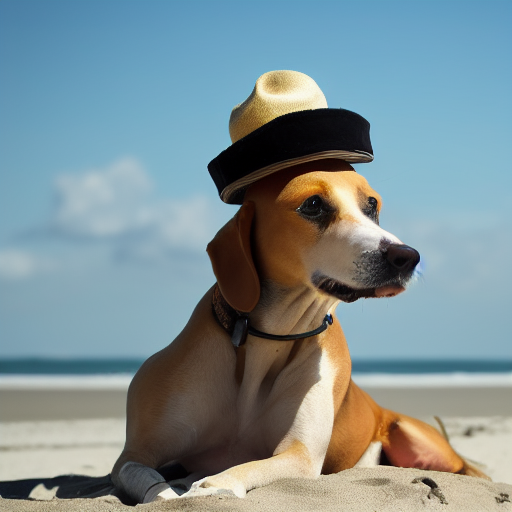

In [47]:
output_img

In [34]:
torch.cuda.empty_cache()